In [184]:
import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from fiveEqSCM_multiscen import *
import scipy as sp

In [523]:
## A well written/ documented fit to Prather:

## We want to fit the period 2010-2100, while keeping the model stable...

## So we need tau = tau_0 in 2010

## and to be fitting to a "similar" temperature / concentration profile as the model will calculate

# 1. with current parameters & emission data, fix r0 such that 2010 lifetime is correct:



## All the "Bitty" code:
  
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

In [524]:
RCP = '85'
RCP_E = pd.read_csv('./RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_C = pd.read_csv('./RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0)

In [530]:
CH4_ems = pd.read_csv('./Other_gas_data/CEDS_CH4_global_emissions_1850_2014.csv',header=None,names=['Year','CH4'],index_col=0)

CH4_pre_1850 = RCP_E.CH4.loc[range(1765,1850)].values * CH4_ems.CH4.loc[1850] / RCP_E.CH4.loc[1850] ## scale pre 1850 emissions to match

CH4_1850_2015 = CH4_ems.CH4.drop_duplicates().values # there are 2x 1970...???

CH4_post_2015 = RCP_E.CH4.loc[range(2015,2501)].values + CH4_ems.CH4.loc[2014] - RCP_E.CH4.loc[2014] # shift post 2014 emissions to match

CH4_arr = np.concatenate((CH4_pre_1850,CH4_1850_2015,CH4_post_2015),axis=0)

CH4_E_full = pd.DataFrame(data=CH4_arr,columns = ['CH4'],index=np.arange(1765,2501))

data = [RCP_E.FossilCO2 + RCP_E.OtherCO2, CH4_E_full.CH4, RCP_E.N2O]

emissions = pd.concat(data,axis=1)

results = multiscen_oxfair(emissions=emissions.values.T,multigas=True,multiscen=False)

default_result_concs = pd.DataFrame(data=results[0].squeeze().T,columns=['CO2','CH4','N2O'],index=np.arange(1765,2501))

default_result_concs['T'] = results[2].flatten()

Emissions input is 2D (n_gases, n_timesteps)


Emissions input is 2D (n_gases, n_timesteps)


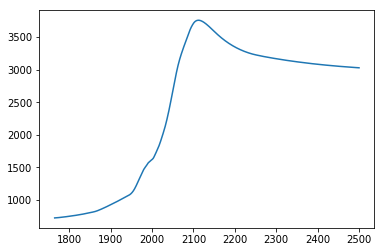

In [585]:
# Test results:

test_results = multiscen_oxfair(emissions=emissions.values.T,multigas=True,multiscen=False,\
                               r = np.array([[32.40,0.019,4.165,0.0],\
                                   [ 8.55710759, 0, -3.60100511e-01,  3.09667588e-04],\
                                   [ 67.23109226573325,  0, 0,  -0.00090625]]),\
                               tau = np.array([[1000000,394.4,36.54,4.304],[9.15,394.4,36.54,4.304],[116.,394.4,36.54,4.304]]))

test_result_concs = pd.DataFrame(data=test_results[0].squeeze().T,columns=['CO2','CH4','N2O'],index=np.arange(1765,2501))

test_result_concs.CH4.plot()

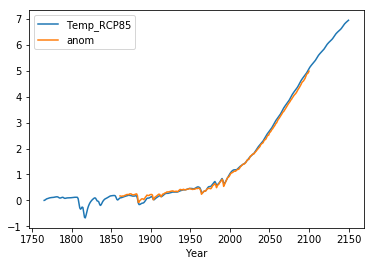

In [552]:
UnFaIR_RCP85_T = pd.read_csv('./CMIP5_Prather_data/RCP85_TEMP_UnFaIR.csv').set_index(np.arange(1765,2151))


fig,ax=plt.subplots()

UnFaIR_RCP85_T.plot(ax=ax)
(CMIP5_RCP85_tas+1.35).plot(ax=ax)

##  Prather model replication

In [577]:
## Prather Approach

# Get data

# Define sat vapour pressure equations:

def Tetens(T):
    T -= 273.15
    return 0.61078 * np.exp(17.27 * T / (T + 237.3) ) # Using Tetens equation
    
def unknown(T):
    return np.exp(20.386 - 5132 / T )
    
def Antoine(T):
    T -= 273.15
    return 10**( 8.07131 - 1730.63 / (233.426 + T) )

def ARM(T):
    T -= 273.15
    return 0.61094 * np.exp( 17.625 * T / (T + 243.04) )

def Buck(T):
    T -= 273.15
    return 0.61121 * np.exp( ( 18.678 - T / 234.5 ) * ( T / ( 257.14 + T ) ) )

def Jacobson05(T):
    return 6.112 * np.exp( 6816 * ( 1 / 273.15 - 1 / T ) + 5.1309 * np.log( 273.15 / T ) )

CMIP5_RCP85_tas = pd.read_csv('CMIP5_Prather_data/CMIP5_RCP85_tas_data.txt',skiprows=31,delim_whitespace=True,header=None,index_col=0,names=['Year','anom'])
T_atmos = 251.9 + 0.94 * ( CMIP5_RCP85_tas - CMIP5_RCP85_tas.loc[2010] )
sat_p_atmos = Jacobson05(T_atmos)
q_atmos = 2.45 * ( 1 + 1.5 * (sat_p_atmos - sat_p_atmos.loc[2010]) / sat_p_atmos.loc[2010] )

In [578]:
pd_ems = 352 # Tg/yr
pd_conc = 1800
tau_other = (1/200+1/120+1/150)**(-1)

emis2conc = 28.97/(5.148*16)

alph_T = -3.
alph_q = -0.32
alph_CH4 = 0.31
alph_NOx = -0.14

ems = RCP_E.CH4.loc[2010:2100] * pd_ems / RCP_E.CH4.loc[2010]

NOx_ems = RCP_E.NOx.loc[2010:2100]

C = np.zeros(ems.size)
C[0] = pd_conc
tau_OH = np.zeros(ems.size)
tau_OH[0] = 11.2
tau = np.zeros(ems.size)
tau[0] = (1/tau_OH[0] + 1/tau_other)**(-1)

C_T = C.copy()
tau_T = tau.copy()
alph_T_T = -14

for i,t in enumerate(ems.loc[2010:2100].index.values[:-1]):
    
    #NB +202 is the natural emissions
    
    C[i+1] = emis2conc * (ems.loc[t]+202) * tau[i] * (1 - np.exp(-1/tau[i])) + C[i] * np.exp(-1/tau[i])
    
    tau_OH[i+1] = tau_OH[i] * (T_atmos.loc[t+1]/T_atmos.loc[t])**(alph_T) * (q_atmos.loc[t+1]/q_atmos.loc[t])**(alph_q) * (C[i+1]/C[i])**(alph_CH4)# * (NOx_ems[t+1]/NOx_ems[t])**(alph_NOx)
    
    tau[i+1] = (1/tau_OH[i+1] + 1/tau_other)**(-1)
    
    C_T[i+1] = emis2conc * (ems.loc[t]+202) * tau_T[i] * (1 - np.exp(-1/tau_T[i])) + C_T[i] * np.exp(-1/tau_T[i])
    
    tau_T[i+1] = tau_T[i] * (T_atmos.loc[t+1]/T_atmos.loc[t])**(alph_T_T) * (C_T[i+1]/C_T[i])**(alph_CH4)

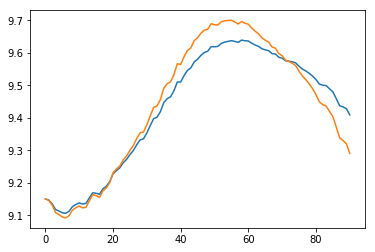

In [579]:
plt.plot(tau)
plt.plot(tau_T)

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here

 final_simplex: (array([[-3.60100511e-01,  3.09667588e-04],
       [-3.60182222e-01,  3.09719043e-04],
       [-3.60081112e-01,  3.09649536e-04]]), array([0.22995648, 0.22995648, 0.22995651]))
           fun: 0.22995647875590577
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 59
        status: 0
       success: True
             x: array([-3.60100511e-01,  3.09667588e-04])
0.8506990885261226 9.148368824046909 [8.55710759]


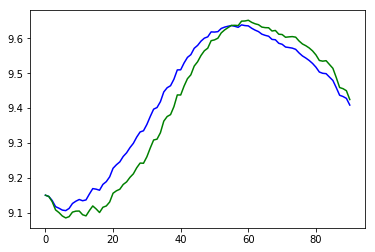

In [580]:
## So we've shown the Prather temp/wv/CH4 sensitivities can be more or less wrapped up in temp/CH4

## Now we need to match the feedback function with our sinh

g1 = tau[0] * (1- (1+100/tau[0])*np.exp(-100/tau[0]))
g0 = (np.sinh(tau[0]*(1-np.exp(-100/tau[0]))/g1))**(-1)

iIRF2010 = np.arcsinh(1/g0) * g1

def mylalph(x):
    
    r0 = iIRF2010 - x[1] * (C[0] - 722)/emis2conc - x[0] * (CMIP5_RCP85_tas.loc[2010].values - CMIP5_RCP85_tas.loc[range(1860,1880)].mean().values)
    
    return np.sum((tau[0] * g0 * np.sinh( ( r0 + x[0] * (CMIP5_RCP85_tas[2010:2100].values.flatten() - CMIP5_RCP85_tas.loc[range(1860,1880)].mean().values) + x[1] * (C - 722)/emis2conc ) / g1 ) - tau)**2)

resultmin = sp.optimize.minimize(mylalph, np.array([0,0]), method='Nelder-Mead')

r0 = iIRF2010 - resultmin['x'][1] * (C[0] - 722)/emis2conc - resultmin['x'][0] * (CMIP5_RCP85_tas.loc[2010].values - CMIP5_RCP85_tas.loc[range(1860,1880)].mean().values)

plt.plot( tau , 'b' )
plt.plot( g0 * tau[0] * np.sinh( ( r0 + resultmin['x'][0] * (CMIP5_RCP85_tas[2010:2100].values.flatten() - CMIP5_RCP85_tas.loc[range(1860,1880)].mean().values) + resultmin['x'][1] * (C-722)/emis2conc ) / g1 ) , 'g' )

print(resultmin)
print(g0,g1,r0)

In [581]:
# Now if we do the same thing for N2O

tau_0 = 116
alph_N2O = -0.065
C_0 = 321
emis2conc = 28.97/(5.148*28)

ems_N2O = RCP_E.N2O.loc[range(2010,2101)] * 6.6 / RCP_E.N2O.loc[2010] # RCP scaled to Prather

C = np.zeros(ems_N2O.size)
tau = np.zeros(ems_N2O.size)
C[0] = C_0
tau[0] = tau_0

for i,t in enumerate(ems_N2O.index.values[:-1]):
    
    C[i+1] = emis2conc * (ems_N2O.loc[t]+10.5) * tau[i] * (1 - np.exp(-1/tau[i])) + C[i] * np.exp(-1/tau[i])
    
    tau[i+1] = tau[i] * (C[i+1] / C[i])**(alph_N2O)

 final_simplex: (array([[-0.00090625],
       [-0.0009082 ]]), array([0.0625669 , 0.06258106]))
           fun: 0.0625668997954208
       message: 'Optimization terminated successfully.'
          nfev: 22
           nit: 11
        status: 0
       success: True
             x: array([-0.00090625])
0.1345122139388309 24.785904398923723 67.23109226573325


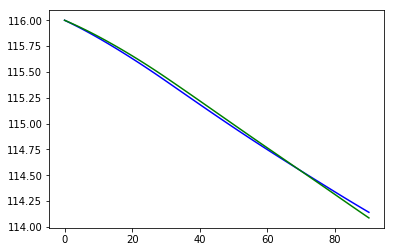

In [582]:
## And reproducing with sinh:

g1 = tau[0] * (1- (1+100/tau[0])*np.exp(-100/tau[0]))
g0 = (np.sinh(tau[0]*(1-np.exp(-100/tau[0]))/g1))**(-1)

iIRF2010 = np.arcsinh(1/g0) * g1

def mylalph(x):
    r0 = iIRF2010 - x[0] * (C[0] -273)/emis2conc
    return np.sum((tau[0] * g0 * np.sinh( ( r0 + x[0] * (C-273)/emis2conc ) / g1 ) - tau)**2)

resultmin = sp.optimize.minimize(mylalph, 0, method='Nelder-Mead')

r0 = iIRF2010 - resultmin['x'][0] * (C[0]-273)/emis2conc

plt.plot( tau , 'b' )
plt.plot( g0 * tau[0] * np.sinh( ( r0 + resultmin['x'][0] * (C-273)/emis2conc ) / g1 ) , 'g' )

print(resultmin)
print(g0,g1,r0)

## CO2 iIRF function validation

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


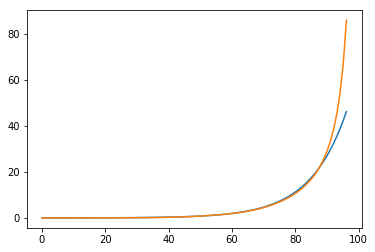

In [346]:
## Final good thing to do: figure for supp. that shows analytic approx vs. numeric solution for CO2

def iIRF(x,targ):
    a = np.array([0.2173,0.2240,0.2824,0.2763])
    tau = np.array([1000000,394.4,36.54,4.304])
    return x * np.sum( a * tau * ( 1. - np.exp( -100./( x * tau ) ) ) ) - targ

def alpha(iIRFval):
    g1= 11.4137978
    g0= 0.020369508
    return g0*np.sinh((iIRFval)/g1)

upbound = 97

alpha_ana = np.zeros(np.arange(0.1,upbound,1).size)
alpha_num = np.zeros(np.arange(0.1,upbound,1).size)

for i,val in enumerate(np.arange(0.1,upbound,1)):
    alpha_ana[i] = alpha(val)
    alpha_num[i] = sp.optimize.root(iIRF,1.,args=(val),method='lm')['x']
    
plt.plot(np.arange(0.1,upbound,1),alpha_ana)
plt.plot(np.arange(0.1,upbound,1),alpha_num)

 final_simplex: (array([[ 0.4607635 ,  0.10385394, -4.54186666,  0.66210816],
       [ 0.46075424,  0.10385483, -4.54192772,  0.66214504],
       [ 0.46078169,  0.10385447, -4.54195554,  0.66212588],
       [ 0.46076113,  0.103854  , -4.54186865,  0.66208539],
       [ 0.46080081,  0.10385359, -4.54192248,  0.66215833]]), array([6.10980534, 6.10980534, 6.10980535, 6.10980538, 6.10980539]))
           fun: 6.109805336702207
       message: 'Optimization terminated successfully.'
          nfev: 707
           nit: 423
        status: 0
       success: True
             x: array([ 0.4607635 ,  0.10385394, -4.54186666,  0.66210816])


(-1, 1)

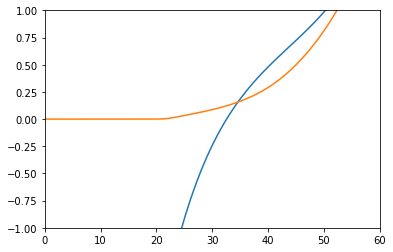

In [371]:
# Nahhhhh

idx = np.argmin(abs(np.arange(0.1,upbound,1)-30))

def fit_alph(x):
    return np.sum((x[3] + x[0] * np.sinh( x[1] * np.arange(0.1,upbound,1)[idx:-5] + x[2]) - alpha_num[idx:-5])**2)

resultfind = sp.optimize.minimize(fit_alph,np.array([1,1,30,1]), method='Nelder-Mead')

print(resultfind)

plt.plot(np.arange(0.1,upbound,1),resultfind['x'][3] + resultfind['x'][0] * np.sinh( resultfind['x'][1] * np.arange(0.1,upbound,1) + resultfind['x'][2]))
plt.plot(np.arange(0.1,upbound,1),alpha_num)

plt.xlim(0,60)
plt.ylim(-1,1)

In [275]:
## The effect of different alphas:

g1= 11.4137978
g0= 0.020369508
r0= 32.4
rC= 0.019
rT= 4.165

def alpha(C,T):
    return g0*np.sinh((r0 + rC*C + rT*T)/g1)

alphafair = alpha(np.arange(0,4000,10),np.arange(0,10,0.1)[:,np.newaxis])


def altalpha(x):
    return np.sum(((x[3] + x[0]*np.exp(x[1]*np.arange(0,4000,10) + x[2]*np.arange(0,10,0.1)[:,np.newaxis])) - alpha(np.arange(0,4000,10),np.arange(0,10,0.1)[:,np.newaxis]))**2)

## This one is "optimized" using Powell minimizer

def nickalpha(C,T):
    return -4.05132919e-05 + 1.74088181e-01 * np.exp( 1.66465179e-03 * C + 3.64909197e-01 * T )

## This would be the one:

def theoryalpha(C,T):
    return ( g0 / 2 ) * ( -np.exp( -r0 / g1 ) + np.exp( (r0 + rC*C + rT*T) / g1 ) )

## Oh boi yes

alphanick = theoryalpha(np.arange(0,4000,10),np.arange(0,10,0.1)[:,np.newaxis])

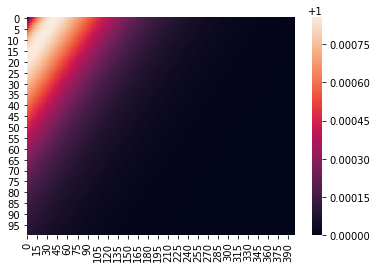

In [245]:
sn.heatmap(alphafair/alphanick)

#plt.plot(alpha(np.arange(0,4000,10),0))
#plt.plot(nickalpha(np.arange(0,4000,10),0))
#plt.plot(theoryalpha(np.arange(0,4000,10),0))